In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
mnist_train = datasets.MNIST('./data_mnist', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data_mnist', train=False, download=True, transform=transform)

In [5]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [6]:
num_classes = 10

In [7]:
label_embeddings = torch.eye(num_classes)

In [8]:
label_embeddings

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### VAE

In [9]:
# Define a custom encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784 + 10, 512)  # Input size is image + label embedding
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * 2)  # *2 for mean and log-variance

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Define a custom decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + 10, 256)  # Input size is latent + label embedding
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [11]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, label_embedding):
        x = torch.cat([x.view(-1, 784), label_embedding], dim=1)
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        z = torch.cat([z, label_embedding], dim=1)
        return self.decoder(z), mu, logvar

In [12]:
# Initialize the VAE model
latent_dim = 20  # Adjust as needed
vae = VAE(latent_dim)

In [13]:
# Loss function: reconstruction loss + KL divergence loss
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [14]:

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [15]:
# Training and testing loop
num_epochs = 40  # Adjust as needed
output_dir = "output_images"  # Directory to save generated images

In [16]:
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        # Convert labels to one-hot embeddings
        label_embedding = label_embeddings[label]

        # Forward pass
        data = data.view(-1, 784)
        recon_batch, mu, logvar = vae(data, label_embedding)

        # Compute the loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backpropagation
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset)}')

    # Testing and saving generated images
    with torch.no_grad():
        vae.eval()
        sample = torch.randn(10, latent_dim)
        labels = torch.randint(0, num_classes, (10,))
        label_embedding = label_embeddings[labels]
        sample = vae.decoder(torch.cat([sample, label_embedding], dim=1))
        vutils.save_image(sample.view(10, 1, 28, 28), f'{output_dir}/sample_epoch_{epoch + 1}.png')

print('Training finished.')

Epoch [1/40], Loss: 137.16609611002605
Epoch [2/40], Loss: 110.68938718261718
Epoch [3/40], Loss: 105.68454294840495
Epoch [4/40], Loss: 103.06906578776042
Epoch [5/40], Loss: 101.52107861328125
Epoch [6/40], Loss: 100.36040305582682
Epoch [7/40], Loss: 99.54917439778646
Epoch [8/40], Loss: 98.88025205891927
Epoch [9/40], Loss: 98.2890864095052
Epoch [10/40], Loss: 97.80712043457031
Epoch [11/40], Loss: 97.4043657063802
Epoch [12/40], Loss: 97.0487772623698
Epoch [13/40], Loss: 96.76085089111328
Epoch [14/40], Loss: 96.50458944905598
Epoch [15/40], Loss: 96.29631314290364
Epoch [16/40], Loss: 96.0025644938151
Epoch [17/40], Loss: 95.82796814371744
Epoch [18/40], Loss: 95.69940540364583
Epoch [19/40], Loss: 95.53872540690104
Epoch [20/40], Loss: 95.38683440348308
Epoch [21/40], Loss: 95.17880946858725
Epoch [22/40], Loss: 95.08691970214844
Epoch [23/40], Loss: 94.90071789550781
Epoch [24/40], Loss: 94.80826834309896
Epoch [25/40], Loss: 94.73435228678386
Epoch [26/40], Loss: 94.63213212

### VAE with MNIST image and right label

In [32]:
image, label = next(iter(test_loader))

In [33]:
image[0].shape, label[0]

(torch.Size([1, 28, 28]), tensor(9))

In [34]:
test_image = image[0].unsqueeze(0)
# test_image.shape
test_embedding = label_embeddings[label[0]]

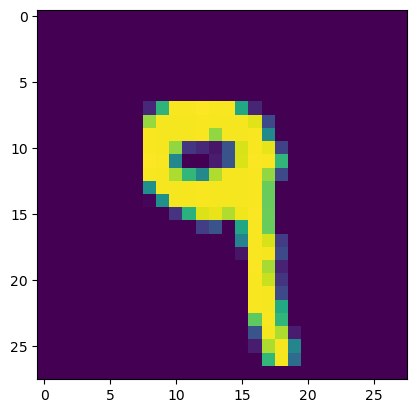

In [35]:
plt.imshow(test_image.squeeze(0).permute(1, 2, 0).numpy())

In [36]:
test_embedding = test_embedding.reshape(1, -1)
test_embedding

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [37]:
recon_output, mu, logvar = vae(test_image, test_embedding)

In [38]:
recon_output.shape

torch.Size([1, 784])

In [39]:
recon_output = recon_output.squeeze().reshape((1, 28, 28))

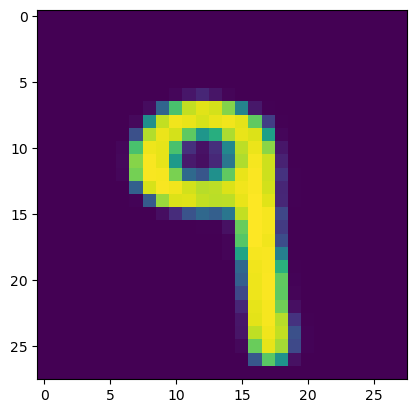

In [40]:
plt.imshow(recon_output.permute(1, 2, 0).detach().numpy())

### VAE with random MNIST Image and wrong label

In [41]:
np.random.choice([1, 2, 3])

2

In [42]:
def plot_results(image, true_label, wrong_label, recon_output):
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(f'True Image with label {wrong_label}')
    plt.grid('off')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(recon_output.permute(1, 2, 0).detach().numpy())
    plt.title('Reconstructed Image')
    plt.grid('off')
    plt.xticks([])
    plt.yticks([])

    plt.show()

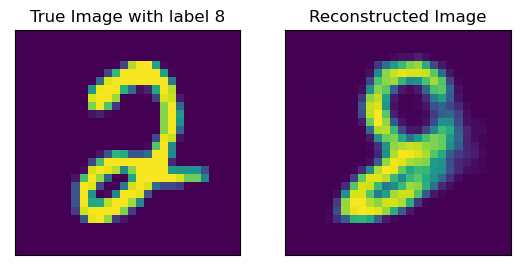

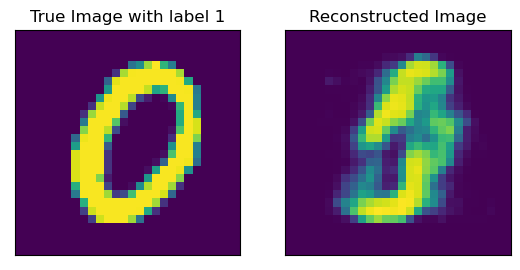

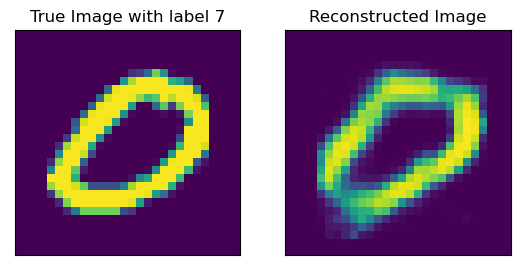

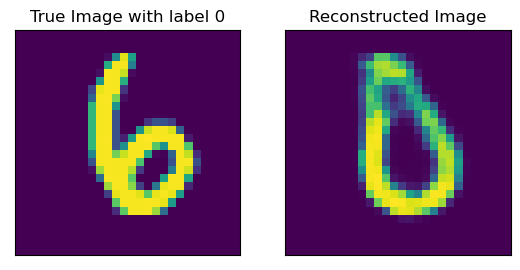

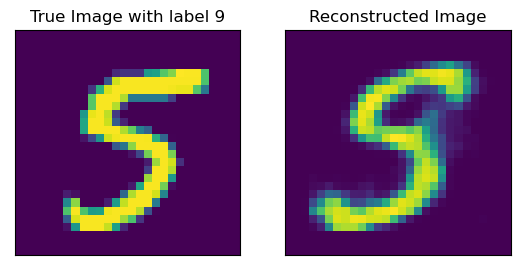

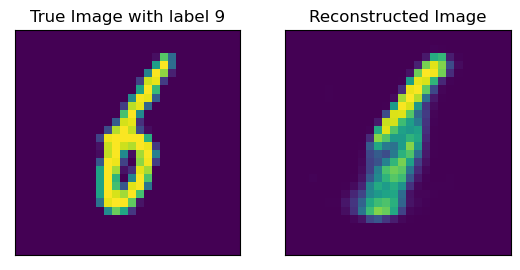

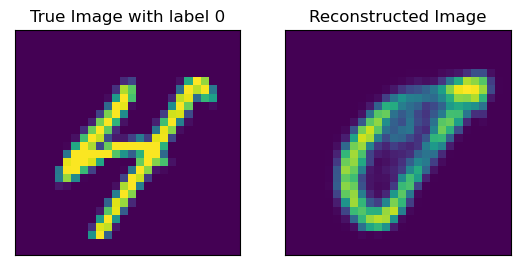

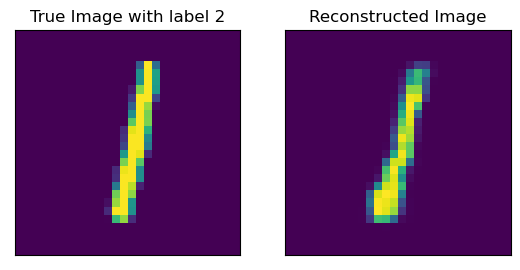

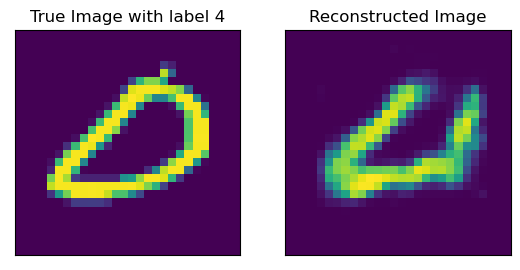

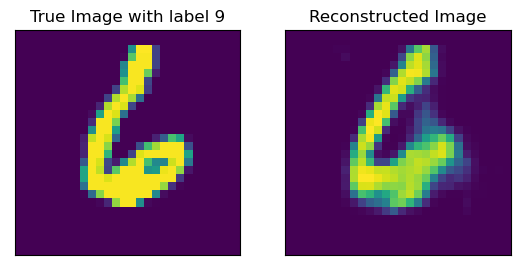

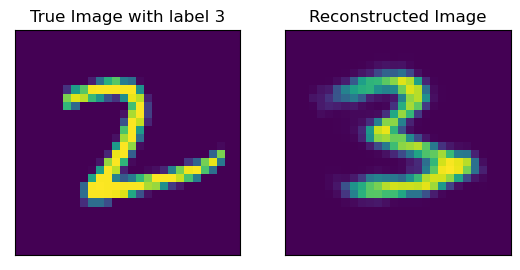

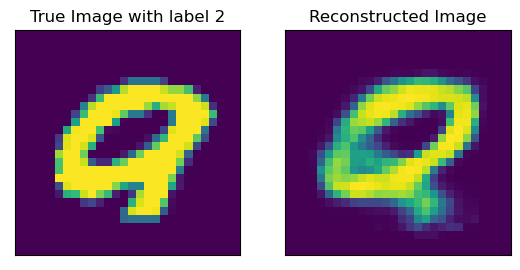

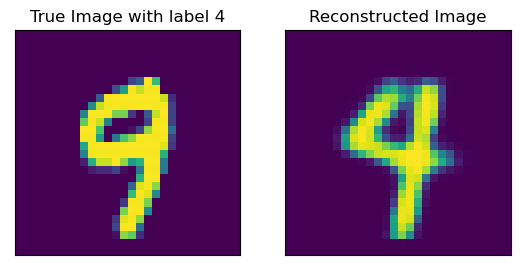

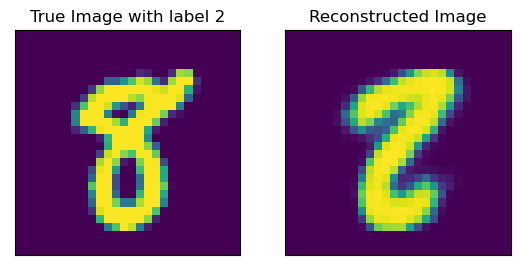

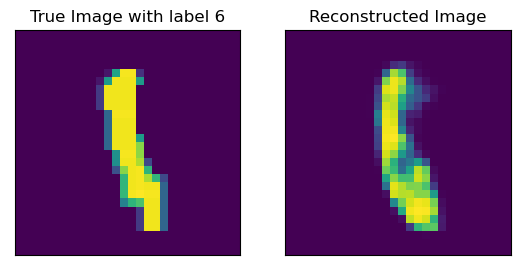

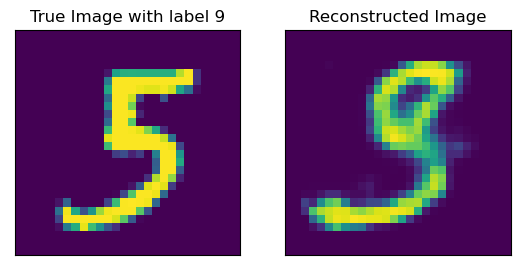

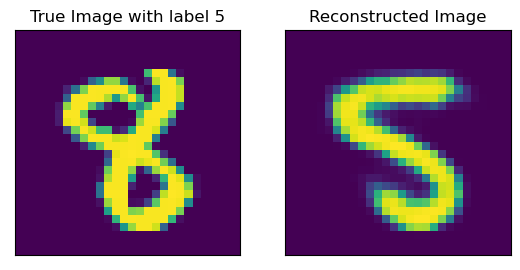

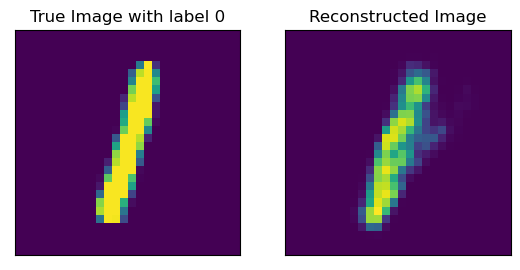

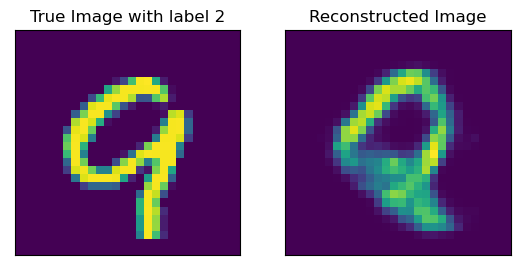

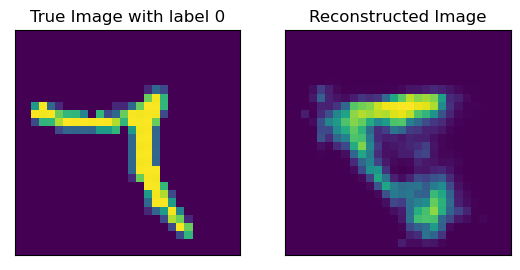

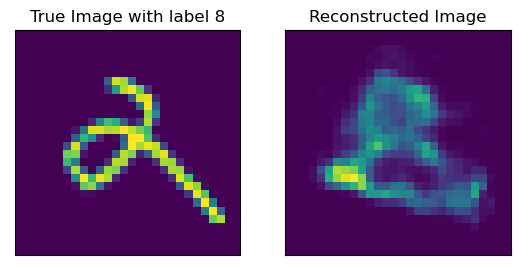

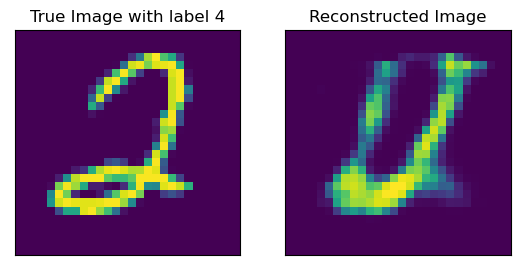

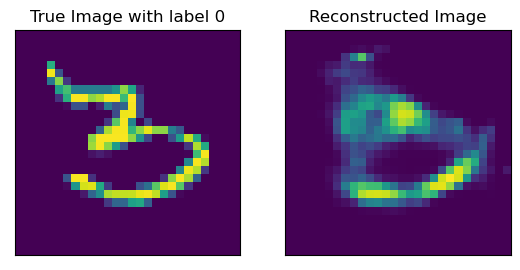

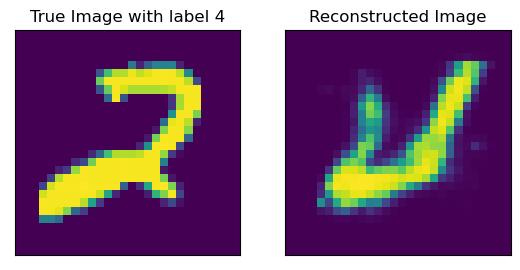

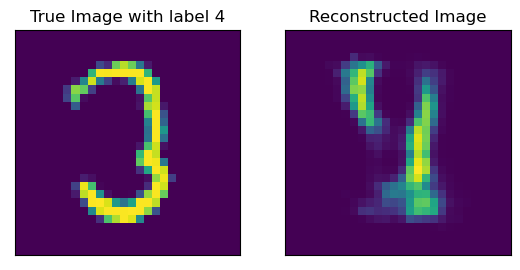

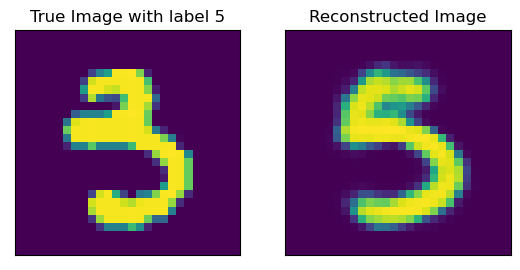

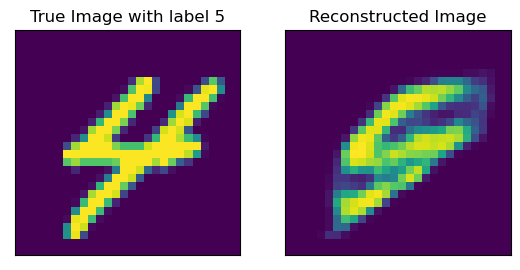

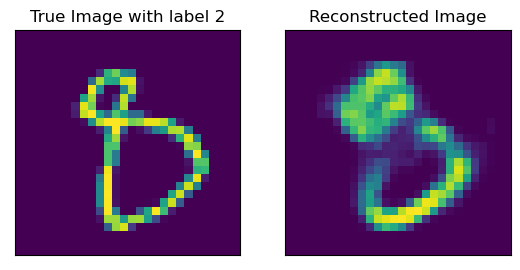

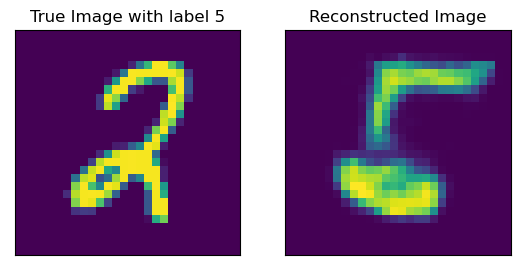

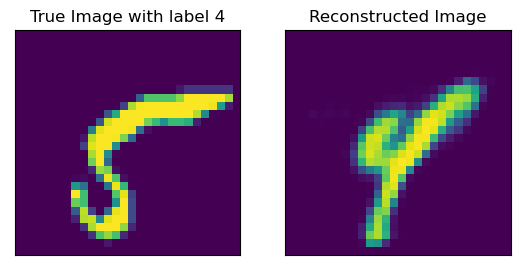

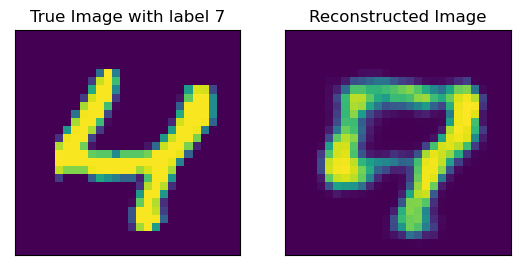

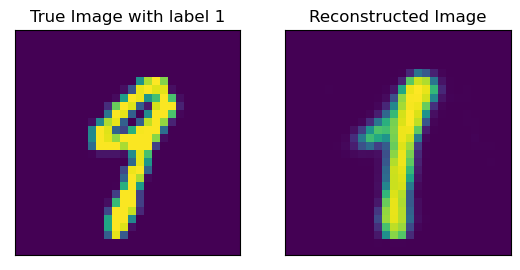

In [43]:
image, label = next(iter(test_loader))
images_dict = {}
counter = 0

for idx, (image, label) in enumerate(zip(image, label)):
    
#     print(f"True Label: {label}")


    
    fake_label_choices = [ i for i in range(10) if i != label]
    fake_label = np.random.choice(fake_label_choices)
    
#     print(f"Wrong Label: {fake_label}")
    
    wrong_label_embedding = label_embeddings[fake_label]
    wrong_label_embedding = wrong_label_embedding.reshape(1, -1)
    
    recon_output, mu, logvar = vae(image, wrong_label_embedding)
    recon_output = recon_output.squeeze().reshape((1, 28, 28))
    
    plot_results(image, label, fake_label, recon_output)
    
    
    
    images_dict[counter] = {'image': image, 'label': label, 'fake_label': fake_label, 'recon': recon_output}
    counter += 1
    

In [29]:
im, la, fkl, rec = images_dict[0].values()

In [30]:
im.shape, la, fkl, rec.shape

(torch.Size([1, 28, 28]), tensor(5), 3, torch.Size([1, 28, 28]))

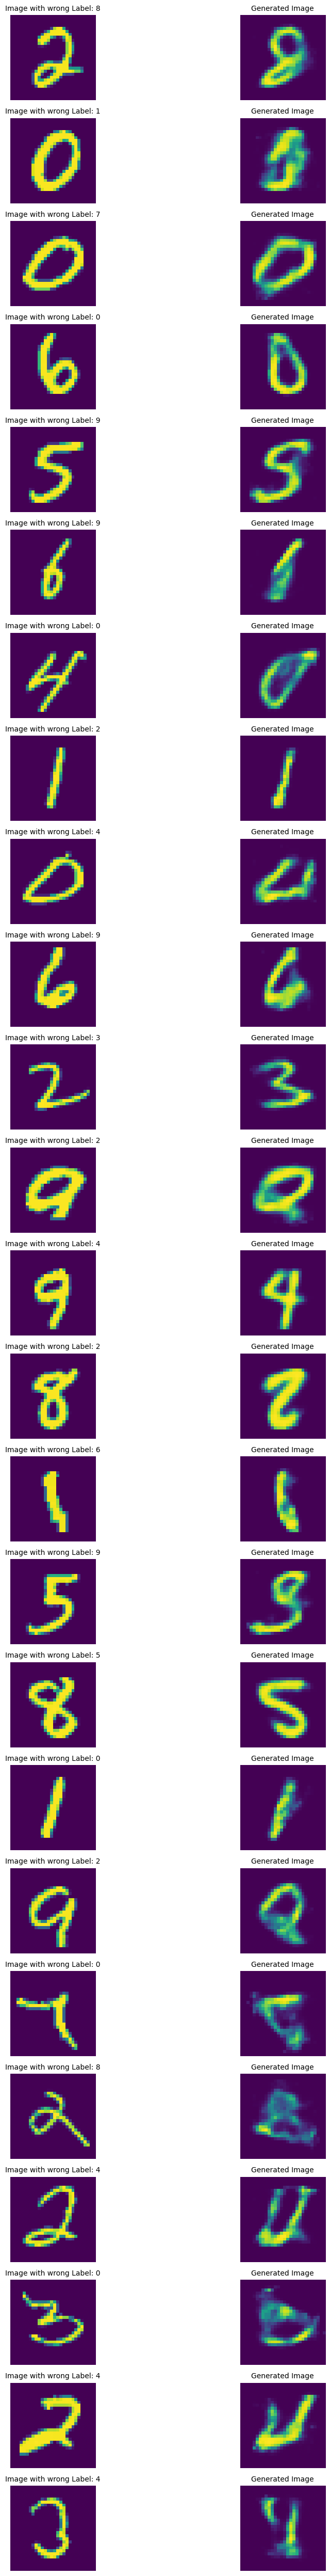

In [45]:
num_rows = 25
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 50))

for i in range(num_rows):
    
    image, label, fake_label, rec = images_dict[i].values()
    
    ax = axs[i, 0]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(f"Image with wrong Label: {fake_label}", fontsize=10)
    ax.axis('off')
    
    ax = axs[i, 1]
    ax.imshow(rec.permute(1, 2, 0).detach().numpy())
    ax.set_title(f"Generated Image", fontsize=10)
    
    ax.axis('off')

plt.tight_layout()
plt.show()